In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise import accuracy
from collections import defaultdict
from surprise.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

In [2]:
#Content Based model
#Reading datasets
movies = pd.read_csv("input/movies.csv")
print(movies.head(5))
links = pd.read_csv("input/links.csv")
print(links.head(5))
# converting the imdbId field to be joinable later
links['imdbId2'] = links['imdbId'].map(str).apply(lambda s: "tt0" + s if len(s) == 6 else "tt" + s)
print(links.head(5))
imdb_movies = pd.read_csv("input/IMDb movies.csv")
print(imdb_movies.head(5))
# joining data sets to obtain contextual information on movies (ie. director, actor, production_company)
movies_links = pd.merge(movies, links, how='inner', on='movieId')
print(movies_links.head(5))
movies_complete = pd.merge(movies_links,imdb_movies,how='inner',left_on='imdbId2',right_on='imdb_title_id')

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0
3        4  114885  31357.0
4        5  113041  11862.0
   movieId  imdbId   tmdbId    imdbId2
0        1  114709    862.0  tt0114709
1        2  113497   8844.0  tt0113497
2        3  113228  15602.0  tt0113228
3        4  114885  31357.0  tt0114885
4        5  113041  11862.0  tt0113041
  i

In [3]:
#finding similarity matrix
def generate_similarity_matrix():
    mc = movies_complete
    # filling in missing data
    mc['genre'].fillna("No genre")
    mc['language'].fillna("language")
    mc['director'].fillna("director")
    mc['writer'].fillna("writer")
    mc['production_company'].fillna("production_company")
    mc['actors'].fillna("actors")
    movies_complete["tokens"] = mc['genre'] + "," + mc['director'] + mc['writer'] + "," + mc['actors'] + "," + mc['production_company']    
    v = TfidfVectorizer(token_pattern = '[a-zA-Z0-9\s]+')
    tfidf_movies_context_matrix = v.fit_transform(movies_complete['tokens'].values.astype('U'))
    cos_sim_matrix = linear_kernel(tfidf_movies_context_matrix, tfidf_movies_context_matrix)
    return cos_sim_matrix
cos_sim_matrix = generate_similarity_matrix()

In [4]:
ratings = pd.read_csv("input/ratings.csv")
def get_movies_watched_by(userID):
    user_filter = ratings['userId'] == userID
    movies_watched = ratings[user_filter]
    return movies_watched

In [5]:
#get list of recommendations from content based model
def get_movie_recommendations_for(userID):
    # get the list of movies that this user has watched
    movies_watched = get_movies_watched_by(userID)
    df_movies_watched = pd.DataFrame()
    for index, row in movies_watched.iterrows():
        i = movies_complete[movies_complete['movieId'] == row['movieId']].index
        df_movies_watched = df_movies_watched.append(movies_complete.loc[i])

    # get similar items based on those movies
    similar_movies = []
    for index, row in df_movies_watched.iterrows():
        # generate top n similar items and add to the similar_movies list
        sim_movies = list(enumerate(cos_sim_matrix[index]))
        sim_movies_sorted = sorted(sim_movies, key=lambda movieid_score_tuple: movieid_score_tuple[1], reverse=True)
        similar_movies = similar_movies + sim_movies_sorted[1:11]
        
    # order the list from highest similarity to lowest similarity
    # recommend the top 10 movies
    similar_movies = sorted(similar_movies, key=lambda movieid_score_tuple: movieid_score_tuple[1], reverse=True)
    top_10_recommendations = similar_movies
    
    # convert the list of movie indexes to movie id
    results_2 = list()
    for movie_score in top_10_recommendations:
        movie_index = movie_score[0]
        movie_score = movie_score[1]
        movieId = movies_complete.iloc[movie_index]['movieId']
        movieTitle = movies_complete.iloc[movie_index]['title_x']
        
        genre = movies_complete.iloc[movie_index]['genre']
        language = movies_complete.iloc[movie_index]['language']
        director = movies_complete.iloc[movie_index]['director']
        writer = movies_complete.iloc[movie_index]['writer']
        production_company = movies_complete.iloc[movie_index]['production_company']
        actors = movies_complete.iloc[movie_index]['actors']
        
        t = (userID, movie_index, movie_score, movieId, movieTitle, genre, language, director, writer, production_company, actors)
        results_2.append(t)
        
    df_results_2 = pd.DataFrame(results_2, columns=['userID', 'movie_index', 'score', 'movieId', 'title', 'genre', 'language', 'director', 'writer', 'production_company', 'actors'])
    
    # need to remove duplicates by only keeping the movie with the highest score
    df_results_2 = df_results_2[df_results_2.groupby(['movieId'],sort=False)['score'].transform(max) == df_results_2['score']]
    
    return df_results_2
    

results = get_movie_recommendations_for(60)
print(results.head(20))

    userID  movie_index     score  movieId  \
0       60         4652  0.323315    91529   
1       60          118  0.319407      153   
2       60          131  0.260609      169   
3       60         1841  0.240042     4366   
4       60         3158  0.237567    33794   
5       60         1438  0.229860     3147   
6       60          485  0.203022      595   
7       60         2261  0.164837     5882   
8       60         3493  0.163960    48780   
9       60         5136  0.160850   109487   
10      60         1988  0.158883     4994   
11      60         1042  0.150519     1914   
12      60         3479  0.148732    48414   
13      60         1427  0.145567     3113   
14      60          681  0.139827     1167   
15      60         4481  0.138606    85342   
16      60          294  0.134499      352   
17      60          292  0.127555      350   
18      60         1820  0.124996     4285   
19      60          727  0.124381     1377   

                                 

In [6]:
#SVD Model
#reading files
df_ratings = pd.read_csv('input/ratings.csv')
df_movies = pd.read_csv('input/movies.csv')
df_ratings = df_ratings.drop(columns= 'timestamp')
print(df_movies.head(5))
print(df_ratings.head(5))

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   userId  movieId  rating
0       1        1     4.0
1       1        3     4.0
2       1        6     4.0
3       1       47     5.0
4       1       50     5.0


In [7]:
#splitting data into train and test sets
train_split, test_split = train_test_split(df_ratings, test_size = 0.25, random_state=20)
print("Training data size:", train_split.shape)   
print("Test data size:", test_split.shape) 
#reader to parse the ratings 
reader = Reader(rating_scale=(1, 5))
#Train and test set
train_build = Dataset.load_from_df(train_split, reader)
test_build = Dataset.load_from_df(test_split, reader)
trainset = train_build.build_full_trainset()
testset = test_build.build_full_trainset().build_testset()
print("Test set size:", len(testset))

Training data size: (75627, 3)
Test data size: (25209, 3)
Test set size: 25209


In [8]:
#Gridsearch to select best parameters
number_of_factors_list = [10,20,25,30,35,40,50,100] 
number_of_epochs_list = [10,20,30,40,50] 
learning_rate_list = [0.9,0.09,0.009,0.1,0.01,0.001] 
regularization_parameter_list = [0.9,0.09,0.009,0.1,0.01,0.001] 
hyper_parameters_set = { 'n_factors': number_of_factors_list, 'n_epochs': number_of_epochs_list, 'lr_all': learning_rate_list,'reg_all': regularization_parameter_list} 
trained_model = SVD 
best_model_selection = GridSearchCV(trained_model,hyper_parameters_set,measures=['rmse'], cv=4) 
best_model_selection.fit(train_build) 
print("Best hyperparameters: ",best_model_selection.best_params['rmse'], "to achieve minimum RMSE: " ,best_model_selection.best_score['rmse'])

Best hyperparameters:  {'n_factors': 100, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1} to achieve minimum RMSE:  0.8640910591024709


RMSE: 0.6809
RMSE: 0.8662
RMSE: 0.6432
RMSE: 0.8642
RMSE: 0.6266
RMSE: 0.8644
RMSE: 0.6125
RMSE: 0.8607
RMSE: 0.6067
RMSE: 0.8625
RMSE: 0.5988
RMSE: 0.8606
RMSE: 0.5842
RMSE: 0.8606
RMSE: 0.5491
RMSE: 0.8576


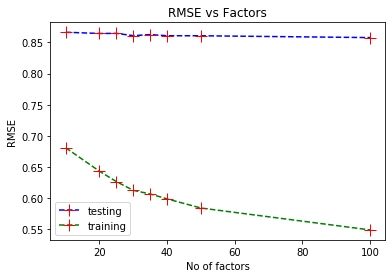

In [9]:
#Factors vs RMSE
validationset = trainset.build_testset()
training_rmse = []
testing_rmse =[]
number_of_factors_list = [10,20,25,30,35,40,50,100]
for factor in number_of_factors_list:
    model = SVD(n_factors=factor,n_epochs=50,lr_all=0.01,reg_all=0.1)
    model.fit(trainset)
    training_predictions = model.test(validationset)
    training_rmse.append(accuracy.rmse(training_predictions))    
    test_predictions = model.test(testset)
    testing_rmse.append(accuracy.rmse(test_predictions))
plt.figure(0)
plt.plot(number_of_factors_list,testing_rmse, 'b+--', markersize=12, markeredgecolor='r',label='testing')
plt.plot(number_of_factors_list,training_rmse, 'g+--', markersize=12, markeredgecolor='r',label='training')
plt.xlabel('No of factors')
plt.ylabel('RMSE')
plt.title("RMSE vs Factors")
plt.legend()

RMSE: 0.7780
RMSE: 0.8784
RMSE: 0.7054
RMSE: 0.8703
RMSE: 0.6364
RMSE: 0.8637
RMSE: 0.5838
RMSE: 0.8602
RMSE: 0.5471
RMSE: 0.8580


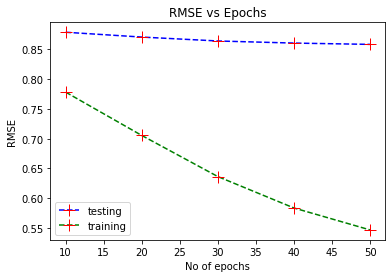

In [10]:
#Epochs vs RMSE
training_rmse = []
testing_rmse =[]
number_of_epochs_list = [10,20,30,40,50]
for epoch in number_of_epochs_list:
    model = SVD(n_factors=100,n_epochs=epoch,lr_all=0.01,reg_all=0.1)
    model.fit(trainset)
    training_predictions = model.test(validationset)
    training_rmse.append(accuracy.rmse(training_predictions))    
    test_predictions = model.test(testset)
    testing_rmse.append(accuracy.rmse(test_predictions))
plt.figure(1)
plt.plot(number_of_epochs_list,testing_rmse, 'b+--', markersize=12, markeredgecolor='r',label='testing')
plt.plot(number_of_epochs_list,training_rmse, 'g+--', markersize=12, markeredgecolor='r',label='training')
plt.xlabel('No of epochs')
plt.ylabel('RMSE')
plt.title("RMSE vs Epochs")
plt.legend()

RMSE: 1.0456
RMSE: 1.0502
RMSE: 0.8162
RMSE: 0.8874
RMSE: 0.5646
RMSE: 0.8588
RMSE: 0.5497
RMSE: 0.8582
RMSE: 0.4745
RMSE: 0.8729
RMSE: 0.4828
RMSE: 0.8760


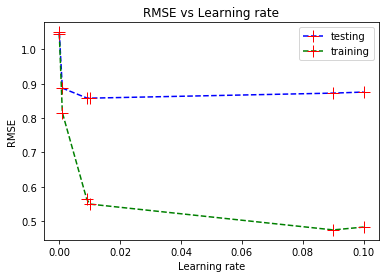

In [11]:
#Effect of learning rate with respect to RMSE
training_rmse = []
testing_rmse =[]
learning_rate_list = [0,0.001,0.009,0.01,0.09,0.1] 
for lr in learning_rate_list:
    model = SVD(n_factors=100,n_epochs=50,lr_all=lr,reg_all=0.1)
    model.fit(trainset)
    training_predictions = model.test(validationset)
    training_rmse.append(accuracy.rmse(training_predictions))    
    test_predictions = model.test(testset)
    testing_rmse.append(accuracy.rmse(test_predictions))
plt.figure(2)
plt.plot(learning_rate_list,testing_rmse, 'b+--', markersize=12, markeredgecolor='r',label='testing')
plt.plot(learning_rate_list,training_rmse, 'g+--', markersize=12, markeredgecolor='r',label='training')
plt.xlabel('Learning rate')
plt.ylabel('RMSE')
plt.title("RMSE vs Learning rate")
plt.legend()

RMSE: 0.0816
RMSE: 0.9885
RMSE: 0.0843
RMSE: 0.9694
RMSE: 0.1232
RMSE: 0.9137
RMSE: 0.1288
RMSE: 0.9125
RMSE: 0.5111
RMSE: 0.8566
RMSE: 0.5494
RMSE: 0.8581


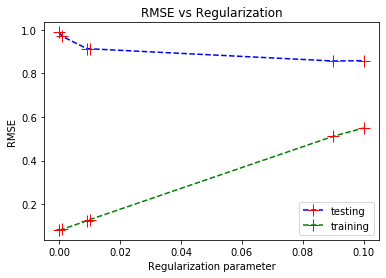

In [12]:
#Regularization parameter and RMSE
training_rmse = []
testing_rmse =[]
regularization_parameter_list = [0,0.001,0.009,0.01,0.09,0.1] 
for reg in regularization_parameter_list:
    model = SVD(n_factors=100,n_epochs=50,lr_all=0.01,reg_all=reg)
    model.fit(trainset)
    training_predictions = model.test(validationset)
    training_rmse.append(accuracy.rmse(training_predictions))    
    test_predictions = model.test(testset)
    testing_rmse.append(accuracy.rmse(test_predictions))
plt.figure(3)
plt.plot(regularization_parameter_list,testing_rmse, 'b+--', markersize=12, markeredgecolor='r',label='testing')
plt.plot(regularization_parameter_list,training_rmse, 'g+--', markersize=12, markeredgecolor='r',label='training')
plt.xlabel('Regularization parameter')
plt.ylabel('RMSE')
plt.title("RMSE vs Regularization")
plt.legend()

In [13]:
#Building model using the best parameters from gridsearch
model = SVD(n_factors=100,n_epochs=50,lr_all=0.01,reg_all=0.1) 
model.fit(trainset) 
predictions = model.test(testset) 
accuracy.rmse(predictions, verbose = True)

RMSE: 0.8580


0.8580080488449664

In [14]:
#Save all the predicted ratings and convert it to a dataframe
all_recommendations_list = defaultdict(list)
all_recommendations_df = pd.DataFrame([])
for uid, iid, true_r, est, _ in predictions:
    all_recommendations_list[uid].append((iid, est))
    all_recommendations_df = all_recommendations_df.append(pd.DataFrame({'user': uid, 'movieId': iid, 'predicted_rating' : est}, index=[0]), ignore_index=True);
print(all_recommendations_df.head(5))
print(all_recommendations_df.shape)

   user  movieId  predicted_rating
0    57     1562          1.841033
1    57      588          3.884800
2    57     2088          2.870226
3    57     3479          3.115561
4    57     2941          3.724608
(25209, 3)


In [15]:
#Append movie info to the predictions
all_recommendations_df_details = pd.merge(all_recommendations_df,df_movies, on='movieId', how='inner')
print(all_recommendations_df_details)

       user  movieId  predicted_rating                       title  \
0        57     1562          1.841033       Batman & Robin (1997)   
1       605     1562          2.168639       Batman & Robin (1997)   
2       608     1562          2.397256       Batman & Robin (1997)   
3       122     1562          2.956092       Batman & Robin (1997)   
4       534     1562          2.778471       Batman & Robin (1997)   
...     ...      ...               ...                         ...   
25204   238     4945          3.535581        Enforcer, The (1976)   
25205     3     2851          2.629771             Saturn 3 (1980)   
25206     3     5181          2.820278            Hangar 18 (1980)   
25207     3     6835          2.581350  Alien Contamination (1980)   
25208   388     6158          3.718728   Jungle Book 2, The (2003)   

                                  genres  
0      Action|Adventure|Fantasy|Thriller  
1      Action|Adventure|Fantasy|Thriller  
2      Action|Adventure|Fantas

In [16]:
#top n recommendations list
def get_top_n_recommendation_list_df(all_recommendations_df_details, n=10):
    top_n_recommendations_df = all_recommendations_df_details.sort_values(['user','predicted_rating'],ascending=[True, False])
    return top_n_recommendations_df
top_n_recommendations_df = get_top_n_recommendation_list_df(all_recommendations_df_details, n=10)
print(top_n_recommendations_df.head())

       user  movieId  predicted_rating  \
11517     1     1136          4.881809   
14801     1     2542          4.749044   
597       1     1256          4.714017   
9330      1     1080          4.701942   
4597      1      110          4.664980   

                                          title                    genres  
11517    Monty Python and the Holy Grail (1975)  Adventure|Comedy|Fantasy  
14801  Lock, Stock & Two Smoking Barrels (1998)     Comedy|Crime|Thriller  
597                            Duck Soup (1933)        Comedy|Musical|War  
9330        Monty Python's Life of Brian (1979)                    Comedy  
4597                          Braveheart (1995)          Action|Drama|War  


In [17]:
#Hybrid model
def hybrid_model(userID):
    content_recommendations_list = get_movie_recommendations_for(userID) #list of movies for that user
    content_recommendations_list= content_recommendations_list[['userID','movieId', 'title', 'genre']]
    for key, columns in content_recommendations_list.iterrows():
        #key is the index of the dataframe, columns are movieid, title and genre
        predict = model.predict(userID, columns["movieId"]) #predicting the rating based on svd model
        content_recommendations_list.loc[key, "predicted rating"] = predict.est #adding a column svd rating and adding prediction value
    return content_recommendations_list.sort_values("predicted rating", ascending=False).iloc[0:11] # return only first 10 movies based on ratings

In [18]:
#calculate evaluation metrics
metrics=[]
true_positives_array = []
est_array = []
for rating_threshold in np.arange(0,5.5,0.5):
    truePositives = 0
    trueNegatives = 0
    falseNegatives = 0
    falsePositives = 0
    accuracy =0
    precision =0
    recall =0
    f1_score = 0
    for uid,_, true_r, est, _ in predictions:
        if(true_r >= rating_threshold and est >= rating_threshold):
            truePositives = truePositives + 1
            true_positives_array.append(true_r)
            est_array.append(est)
        elif(true_r >= rating_threshold and est <= rating_threshold):
            falseNegatives = falseNegatives + 1
        elif(true_r <= rating_threshold and est >= rating_threshold):
            falsePositives = falsePositives + 1
        elif(true_r <= rating_threshold and est <= rating_threshold):
            trueNegatives = trueNegatives + 1
        if(truePositives > 0):
            accuracy = (truePositives + trueNegatives ) / (truePositives + trueNegatives + falsePositives + falseNegatives) 
            precision = truePositives / (truePositives + falsePositives)
            recall = truePositives / (truePositives + falseNegatives)
            f1_score = 2 * (precision * recall) / (precision + recall)           
    metrics.append([rating_threshold,truePositives,trueNegatives,falsePositives,falseNegatives,accuracy,precision,recall,f1_score])
    metrics_df = pd.DataFrame(metrics)
    metrics_df.rename(columns={0:'rating_threshold', 1:'truePositives', 2: 'trueNegatives', 3: 'falsePositives', 4:'falseNegatives', 5: 'Accuracy', 6: 'Precision', 7:'Recall', 8:'F1 Score'},inplace=True)
true_bin_array =[]
for x in true_positives_array:
    if x >= rating_threshold:
        x = 1
    else:
        x = 0
    true_bin_array.append(x)
auc_score = roc_auc_score(true_bin_array,est_array,multi_class='raise',average='macro')    
print('AUC Score: ',auc_score)

AUC Score:  0.7764337266368587


In [19]:
#calculate precision @ k and recall @ k
def get_precision_recall_at_n(predictions,topn,rating_threshold):
    all_actual_predicted_list = defaultdict(list)
    precision = dict()
    recall= dict()
    no_of_relevant_items = 0
    no_of_recommended_items_at_top_n = 0
    no_of_relevant_recommended_items_at_top_n = 0
    for uid, iid, true_r, est, _ in predictions:
        all_actual_predicted_list[uid].append((est, true_r))
    for uid, user_ratings in all_actual_predicted_list.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        no_of_relevant_items = sum((true_r >= rating_threshold) for (_, true_r) in user_ratings)
        no_of_recommended_items_at_top_n = sum((est >= rating_threshold) for (est, _) in user_ratings[:topn])
        no_of_relevant_recommended_items_at_top_n = sum(((true_r >= rating_threshold) and (est >= rating_threshold)) for (est, true_r) in user_ratings[:topn])
        
        precision[uid] = no_of_relevant_recommended_items_at_top_n / no_of_recommended_items_at_top_n if no_of_recommended_items_at_top_n != 0 else 1
        recall[uid] = no_of_relevant_recommended_items_at_top_n / no_of_relevant_items if no_of_relevant_items != 0 else 1
        
    return precision, recall
rating_threshold=3
precision_recall_at_n = []
all_precision = 0
all_recall = 0
for topn in range(2,20):
    precision, recall = get_precision_recall_at_n(predictions,topn,rating_threshold)
    precision_at_n = sum(prec for prec in precision.values()) / len(precision)
    recall_at_n = sum(rec for rec in recall.values()) / len(recall)   
    precision_recall_at_n.append({'topN' : topn, 'Precision' : precision_at_n, 'Recall': recall_at_n})
for n in range(3,9):
    print(precision_recall_at_n[n])

{'topN': 5, 'Precision': 0.9240437158469951, 'Recall': 0.37492492518305875}
{'topN': 6, 'Precision': 0.9233333333333338, 'Recall': 0.42654362152154235}
{'topN': 7, 'Precision': 0.9207572209211546, 'Recall': 0.46865149908545645}
{'topN': 8, 'Precision': 0.9176249024199842, 'Recall': 0.5029427314011048}
{'topN': 9, 'Precision': 0.9177842831121528, 'Recall': 0.534561756776913}
{'topN': 10, 'Precision': 0.9154345563361949, 'Recall': 0.5600310993608318}


In [23]:
#get user liked and high rated movies
all_movie_df_details = pd.merge(df_ratings,df_movies, on='movieId', how='inner')
all_movie_df_details = all_movie_df_details.sort_values(['userId','rating'],ascending=[True, False])
all_movie_df_details.loc[all_movie_df_details['userId'] == 60].head(10)

,userId,movieId,rating,title,genres
3591,60,527,5.0,Schindler's List (1993),Drama|War
17079,60,58559,5.0,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX
45373,60,858,5.0,"Godfather, The (1972)",Crime|Drama
2763,60,362,4.0,"Jungle Book, The (1994)",Adventure|Children|Romance
15385,60,3386,4.0,JFK (1991),Drama|Mystery|Thriller
16328,60,318,4.0,"Shawshank Redemption, The (1994)",Crime|Drama
22569,60,2150,4.0,"Gods Must Be Crazy, The (1980)",Adventure|Comedy
33315,60,783,4.0,"Hunchback of Notre Dame, The (1996)",Animation|Children|Drama|Musical|Romance
51022,60,6016,4.0,City of God (Cidade de Deus) (2002),Action|Adventure|Crime|Drama|Thriller
63673,60,3424,4.0,Do the Right Thing (1989),Drama


In [22]:
#output of hybrid model which shows recommendations from user 60
hybrid_model(60)

,userID,movieId,title,genre,predicted rating
15,60,85342,Elite Squad: The Enemy Within (Tropa de Elite ...,"Action, Crime, Drama",4.279039
111,60,2761,"Iron Giant, The (1999)","Animation, Action, Adventure",4.068112
44,60,457,"Fugitive, The (1993)","Action, Crime, Drama",4.040468
0,60,91529,"Dark Knight Rises, The (2012)","Action, Thriller",4.017080
28,60,55721,Elite Squad (Tropa de Elite) (2007),"Action, Crime, Drama",4.016990
9,60,109487,Interstellar (2014),"Adventure, Drama, Sci-Fi",4.010989
129,60,5902,Adaptation (2002),"Comedy, Drama",4.010680
88,60,5444,Lilo & Stitch (2002),"Animation, Adventure, Comedy",4.003944
4,60,33794,Batman Begins (2005),"Action, Adventure",4.000266
101,60,1095,Glengarry Glen Ross (1992),"Crime, Drama, Mystery",3.991991
